<a href="https://colab.research.google.com/github/emadfrj/Machine-Learning-Holiday-Booking/blob/main/Holiday_Booking_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Holiday Booking
This code employs machine learning to classify the flight booking dataset associated with British Airways. The goal is to develop a model that predicts whether a customer will book a holiday with British Airways.
First, Random Forest is used for calculating feature importance scores. Then variables with less impact on booking is removed from dataset. Finally, both random forest and neural network is used for prediction and the accuracy of them is compared.

## Read dataset
Read dataset from github

In [ ]:
import pandas as pd
# Load the dataset CSV file from github
file_path = 'https://raw.githubusercontent.com/emadfrj/Databases/main/customer_booking.csv'
df_raw = pd.read_csv(file_path, encoding='latin-1')

## Clean Data
A function to perform one-hot encoding while limiting the number of generated columns for categorical variables with high variability.

In [ ]:
import pandas as pd

def efficientOneHotencoding(df, varName, minColumns=10, maxColumns=100, cutPercent=0.1, OtherColumnName = 'Other'):
    """
    Applies one-hot encoding to a DataFrame column while merging infrequent
    categories into a unified group labeled as 'varName_Other'.
    Finally, Frequency Encoding will be applied on 'varName_Other' column.

    Parameters:
    df (DataFrame): The DataFrame containing the data to be encoded.
    varName (str): The name of the column to be encoded.
    minColumns (int): If the number of distinct values is less than this, one-hot encoding will be applied to all the distinct values.
    maxColumns (int): The maximum number of distinct values to consider for one-hot encoding.
    cutPercent (float): The percentage of the mean frequency used as a threshold to determine if a value should be categorized as 'Other'.

    Returns:
    DataFrame: The DataFrame with one-hot encoded columns.
    """

    # Calculate the number of distinct values in the column
    distinctValues = len(df[varName].unique())

    # If there are fewer unique values than the minimum threshold, apply one-hot encoding directly
    if distinctValues <= minColumns:
        return pd.get_dummies(df, columns=[varName], drop_first=True)

    # Calculate the frequency of each value and determine the threshold for 'Other' categorization
    counts_per_group = (df.groupby(varName).size() / len(df)).sort_values(ascending=False)
    # This column is used for making the 'Other_varName_encoded' column Frequency Encoding
    df['Frequency_'+varName] = df[varName].map(counts_per_group)
    # Compute the mean frequency of the top `minColumns - 1` most frequent values in the column.
    # This average frequency serves as a reference point for determining the threshold below which categories will be grouped as 'Other'.
    highFrequencyMean = counts_per_group[1:minColumns].mean()
    thresholdFrequency = highFrequencyMean * cutPercent


    # Determine the rank at which values are categorized  as 'Other'
    rankFrequency = minColumns
    for rankFrequency in range(minColumns, min(maxColumns+1, distinctValues)):
        if counts_per_group[rankFrequency] < thresholdFrequency:
            break

    # Map values to their corresponding categories including 'Other'
    # Map each value to it self
    map_values = dict(zip(counts_per_group.index[:rankFrequency], counts_per_group.index[:rankFrequency]))
    # Map each value to 'varName_Other'
    map_values.update({key: OtherColumnName for key in counts_per_group.index[rankFrequency:]})
    df[varName] = df[varName].map(map_values)
    # Perform one-hot encoding on the modified column
    encoded_df = pd.get_dummies(df, columns=[varName], drop_first=True)
    # Apply Frequency Encoding on 'varName_Other' column
    encoded_df[varName +'_'+OtherColumnName] = encoded_df['Frequency_'+varName] * encoded_df[varName +'_'+OtherColumnName]
    # drop frequency column
    encoded_df.drop('Frequency_'+varName, axis=1, inplace=True)
    return encoded_df


Turn category variables into numerical classes.
Perform one-hot encoding and binary encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
# make a copy of the dataset
df = df_raw.copy()
# Lable encoding(Binary)
label_encoder = LabelEncoder()
df['sales_channel'] = label_encoder.fit_transform(df['sales_channel'])
# One-hot-encoding
df = pd.get_dummies(df, columns=['sales_channel'], drop_first=True)
df = pd.get_dummies(df, columns=['trip_type'], drop_first=True)
df = pd.get_dummies(df, columns=['flight_day'], drop_first=True)
# One-hot-encoding. Limiting the number of columns created
df = efficientOneHotencoding(df,'route',20,1000,0.2)
df = efficientOneHotencoding(df,'booking_origin',20,1000,0.1)

Check the final number of columns after encoding

In [ ]:
len(df.columns)

138

## Split dataset to train and test

In [ ]:
from sklearn.model_selection import train_test_split

# Assume 'target_column' is the column you want to predict
X = df.drop('booking_complete', axis=1)  # Input variable
Y = df['booking_complete']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=35)

## Oversampling for completed booking
Due to the relatively low number of completed booking entries compared to those not booked, some of the data for completed bookings are replicated.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, Y_train_oversampled = oversampler.fit_resample(X_train, Y_train)

print((Y_train_oversampled == 1).sum() /Y_train_oversampled.count())

0.5


## Scalling the inputs

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)
Y_train_scaled = Y_train_oversampled   #it is already scaled

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create and train the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=35)
random_forest_model.fit(X_train_scaled, Y_train_scaled)

# Make predictions on the test set
Y_pred = random_forest_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display additional metrics
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8472
           1       0.45      0.24      0.32      1528

    accuracy                           0.84     10000
   macro avg       0.66      0.60      0.61     10000
weighted avg       0.81      0.84      0.82     10000



## Feature Importance

In [ ]:
# Extract feature importances
feature_importances = random_forest_model.feature_importances_

# Create a list of tuples containing feature and importance
feature_importance_tuples = list(zip(X_train.columns, feature_importances))

# Sort the list of tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Print the sorted features
print("Feature Importances:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Plot feature importance to find the best threshold to disregard low influential variables.

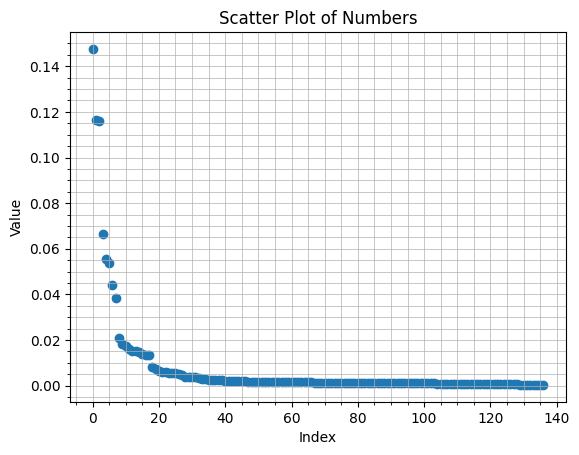

In [ ]:
import matplotlib.pyplot as plt

numbers = [x[1] for x in sorted_feature_importance]

# Create a scatter plot
plt.scatter(range(len(numbers)), numbers)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Numbers')

# Customize gridlines
plt.grid(True, which='both', linestyle='-', linewidth=0.5)  # Show both major and minor gridlines
plt.minorticks_on()  # Enable minor ticks

plt.show()



## Feature Extraction
Remove variables with less than 0.01 importance coefficient

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Select features based on importance
sfm = SelectFromModel(random_forest_model, threshold=0.01)
sfm.fit(X_train_scaled, Y_train_scaled)
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

## Second Random Forest

In [ ]:
# Train the model on the selected features
random_forest_model_selected = RandomForestClassifier(n_estimators=100, random_state=35)
random_forest_model_selected.fit(X_train_selected, Y_train_scaled)

# Make predictions on the test set
Y_pred_selected = random_forest_model_selected.predict(X_test_selected)

# Evaluate the model with selected features
accuracy_selected = accuracy_score(Y_test, Y_pred_selected)
print(f"\nAccuracy with selected features: {accuracy_selected:.2f}")

# Display additional metrics with selected features
print("\nClassification Report with selected features:")
print(classification_report(Y_test, Y_pred_selected))


Accuracy with selected features: 0.84

Classification Report with selected features:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8472
           1       0.44      0.21      0.28      1528

    accuracy                           0.84     10000
   macro avg       0.66      0.58      0.60     10000
weighted avg       0.80      0.84      0.81     10000



## Neural Network

In [ ]:
# Import necessary libraries
import tensorflow as tf

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # binary crossentropy for regression

# Train the model
model.fit(X_train_selected, Y_train_scaled, epochs=20, batch_size=32)

# Evaluate the model
Y_pred_NN = model.predict(X_test_selected)
# Evaluate the model on the test set
accuracy = model.evaluate(X_test_selected, Y_test)[1]
print(f"Test Accuracy: {accuracy}")

Y_pred_class = list(map(lambda x: 1 if x > 0.5 else 0, Y_pred_NN))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_class))

Epoch 1/20
2129/2129 [==============================] - 6s 2ms/step - loss: 0.6293 - accuracy: 0.6490
Epoch 2/20
2129/2129 [==============================] - 6s 3ms/step - loss: 0.6142 - accuracy: 0.6656
Epoch 3/20
2129/2129 [==============================] - 5s 2ms/step - loss: 0.6101 - accuracy: 0.6706
Epoch 4/20
2129/2129 [==============================] - 5s 2ms/step - loss: 0.6072 - accuracy: 0.6715
Epoch 5/20
2129/2129 [==============================] - 5s 2ms/step - loss: 0.6046 - accuracy: 0.6728
Epoch 6/20
2129/2129 [==============================] - 5s 2ms/step - loss: 0.6026 - accuracy: 0.6752
Epoch 7/20
2129/2129 [==============================] - 6s 3ms/step - loss: 0.6012 - accuracy: 0.6747
Epoch 8/20
2129/2129 [==============================] - 5s 2ms/step - loss: 0.6005 - accuracy: 0.6751
Epoch 9/20
2129/2129 [==============================] - 6s 3ms/step - loss: 0.5991 - accuracy: 0.6769
Epoch 10/20
2129/2129 [==============================] - 5s 2ms/step - loss: 0.598